# Demo of Functions in fit_template.R


In [1]:
### load template fitting code and templates
source("fit_template.R") ## fits model
load("template_sdss.RData") ## template for sdss filters, in tem_sdss
load("template_des.RData") ## template for des filters, in tem_des
ls()

[1] "AmpMuDustUpdate"    "AugmentData"        "CheckLC"           
 [4] "CheckNumberBands"   "CheckTemLC"         "ComputeBeta"       
 [7] "ComputeBetaOne"     "ComputeCoeffs"      "ComputeCoeffsPhase"
[10] "ComputeRSSPhase"    "ConstructGamma"     "FitTemplate"       
[13] "NewtonUpdate"       "PredictAllBand"     "PredictSingleBand" 
[16] "PredictTimeBand"    "TBMEtoLC"           "tem_des"           
[19] "tem_sdss"

In [2]:
## read in sdss light curve and plot
fname <- "LC_4099.dat"
lc <- read.table(fname,stringsAsFactors=FALSE)
names(lc) <- c("time","band","mag","error")



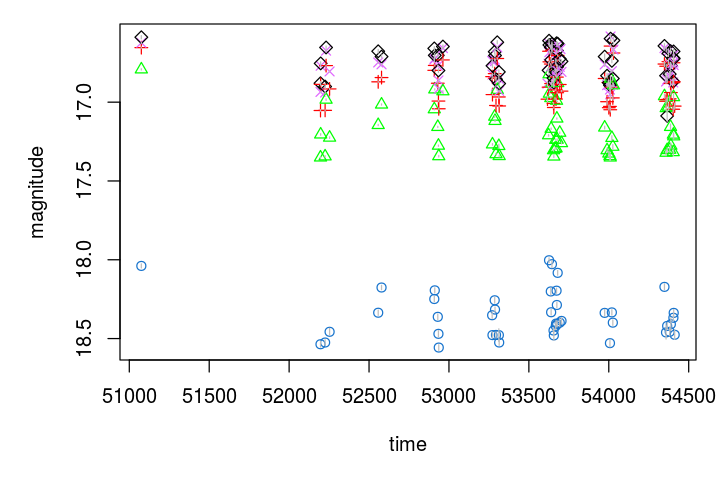

In [5]:
## colors for plotting
options(repr.plot.width=6,repr.plot.height=4)
bandpch <- 1:6
names(bandpch) <- c("u","g","r","i","z","Y")
bandcol <- c("dodgerblue3","green","red",
             "mediumorchid1","black","peachpuff4")
names(bandcol) <- c("u","g","r","i","z","Y")

## plot raw light curve
par(mar=c(5,5,1,1))
plot(lc$time,lc$mag,col=bandcol[lc$band],pch=bandpch[lc$band],
     ylim=rev(range(lc$mag)),
     xlab="time",ylab="magnitude")
segments(lc$time,lc$mag+lc$error,lc$time,lc$mag-lc$error,col='grey')


In [6]:
## plots template fit on light curve, used later
plotLC <- function(lc,p_est,coeffs,tem){
    lc1 <- lc
    lc1[,1] <- (lc$time %% p_est)/p_est
    lc2 <- lc1
    lc2[,1] <- lc1[,1] + 1
    lc_temp <-rbind(lc1,lc2)
    plot(lc_temp$time,lc_temp$mag,
         col=bandcol[lc_temp$band],pch=bandpch[lc_temp$band],
         ylim=rev(range(lc_temp$mag)),
         xlab="phase",ylab="magnitude",
         xlim=c(0,2),xaxs='i')
    segments(lc_temp$time,
             lc_temp$mag+lc_temp$error,
             lc_temp$time,
             lc_temp$mag-lc_temp$error,col='grey')
    ti <- seq(0,p_est,length.out=100)
    ti <- c(ti,ti+p_est)
    m <- PredictAllBand(ti,1/p_est,coeffs,tem)
    for(ii in 1:ncol(m)){
        points(ti/p_est,m[,ii],type='l',col=bandcol[colnames(m)[ii]])
    }
}


## Model Tests

### DEMO 1: Fitting for dust and using photometric errors

The residual sum of squares (RSS) measures quality of model fit. The period estimate is the period which minimizes the RSS. For well sampled RR Lyrae, there should be one clear minumum.

[1] 60373

[1] 0.6417574

mu         ebv         amp       phase 
16.17414602  0.05137342  0.58985301  0.44083043

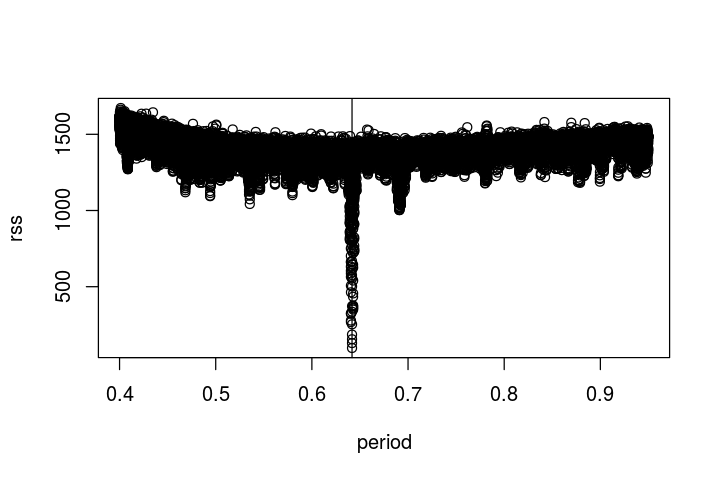

In [7]:
## construct frequency grid
freq_min <- 1.0/0.95 ## max period of rrab is about 0.95 days 
freq_max <- 1.0/0.4 ## min period of rrab is about 0.4 days
max_phase_error <- .02 ## maximum phase error fraction, see documentation
freq_space <- (max_phase_error*4)/(max(lc[,1]) - min(lc[,1]))
omegas <- seq(from=freq_min,to=freq_max,by=freq_space)
length(omegas) ## longer omegas, more computation time, but less risk of missing rss min

## compute model fit at each frequency (low rss = good fit)
rss <- FitTemplate(lc,omegas,tem_sdss)
omega_est <- omegas[which.min(rss)]

## obtain parameter estimates
p_est <- 1/omega_est
p_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss) ## at fixed frequency, determines mu, ebv, amp, phase
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
## correct values near:
## > coeffs
##          mu         ebv         amp       phase 
## 16.17423839  0.05122597  0.58949080  0.24304752 
## p_est
## [1] 0.6417558

## check rss as function of period, hopefully single, unambiguous global min
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)



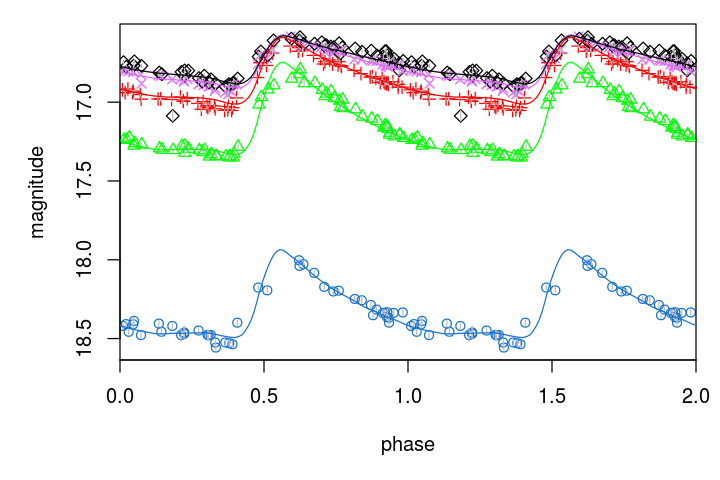

In [9]:
## plot folded light curve with best fit
par(mar=c(5,5,1,1))
plotLC(lc,p_est,coeffs,tem_sdss)

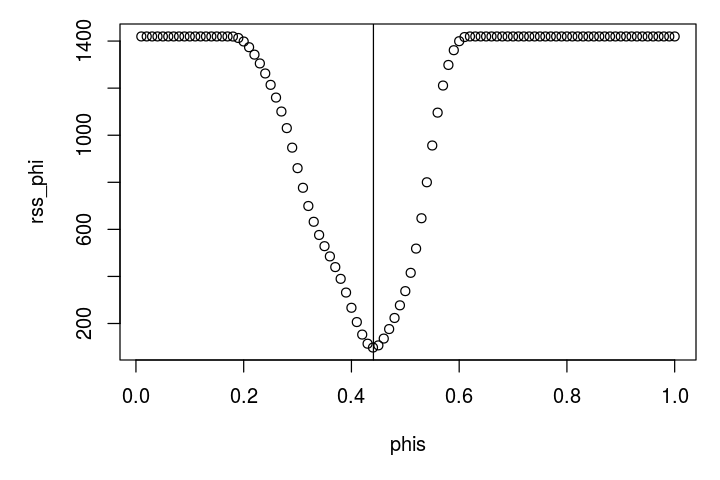

In [10]:
## check that phase determined by NewtonUpdate is close to best phase
## by performing a grid search on phase, comparing min of grid
## search to min found by newton
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis)
par(mar=c(5,5,1,1))
plot(phis,rss_phi)
abline(v=coeffs[4])


### DEMO 2
Refit model, subtracting off dust first here we test if model works when use.dust=FALSE we use dust computed from earlier run (coeffs[2]), but in practice would use values from dust maps.


In [11]:
ebv <- coeffs[2]
## remove dust
bands <- names(tem_sdss$dust)
for(ii in 1:length(bands)){
    lc$mag[lc$band==bands[ii]] <- lc$mag[lc$band==bands[ii]] - tem_sdss$dust[ii]*ebv
}

## compute RSS, get parameters
rss <- FitTemplate(lc,omegas,tem_sdss,use.dust=FALSE)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss,use.dust=FALSE)
names(coeffs) <- c("mu","ebv","amp","phase")

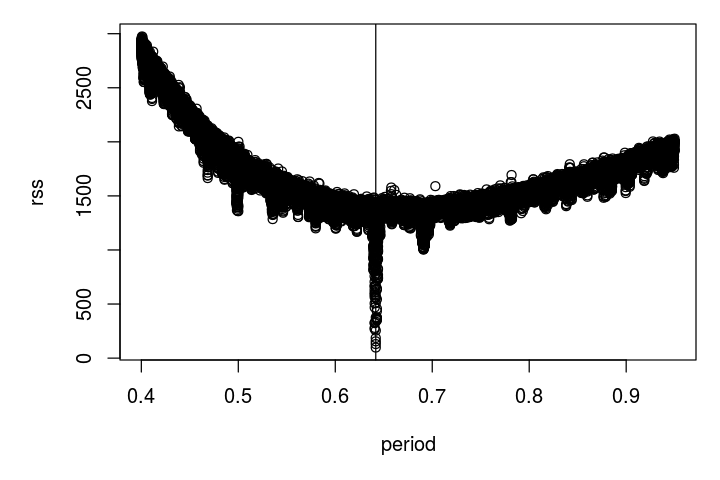

In [12]:
## view rss
par(mar=c(5,5,1,1))
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

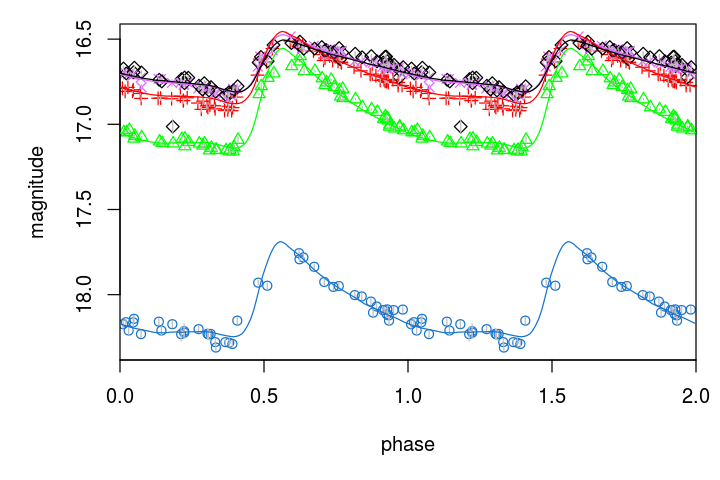

In [13]:
## plot folded light curve with best fit
par(mar=c(5,5,1,1))
plotLC(lc,p_est,coeffs,tem_sdss)

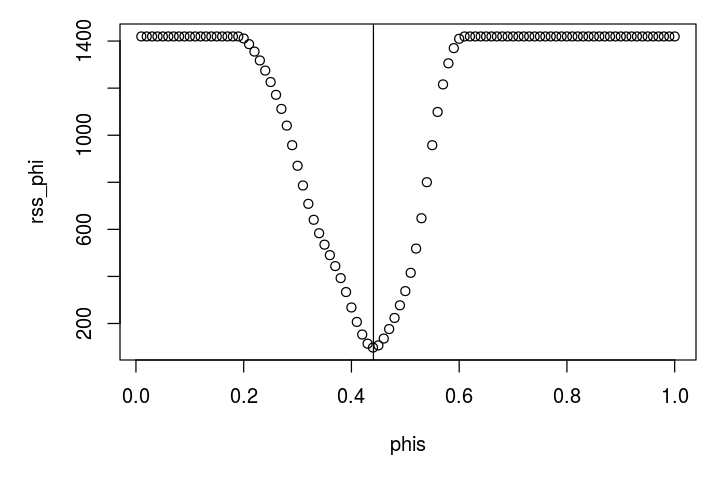

In [14]:
## check that phase determine by NewtonUpdate is close to best phase
## by performing a grid search
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis,use.dust=FALSE)
par(mar=c(5,5,1,1))
plot(phis,rss_phi)
abline(v=coeffs[4])

### DEMO 3
Add large amounts of noise to light curve. Fit the model with use.errors=TRUE and use.errors=FALSE. With very bad observations and use.errors=FALSE, output is crummy, but with use.errors=TRUE, bad data is downweighted and results are okay.

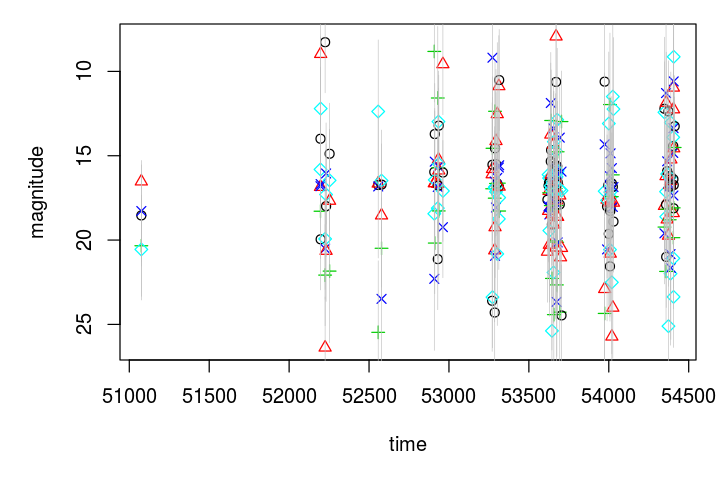

In [16]:
## add lots of error to selected observations
ix <- sample(1:nrow(lc),floor(nrow(lc)*.6))
lc[ix,3] <- lc[ix,3] + rnorm(length(ix),mean=0,sd=3)
lc[ix,4] <- sqrt(lc[ix,4]^2 + 3^2)

## plot raw light curve
colpch <- 1:5
names(colpch) <- unique(lc$band)
par(mar=c(5,5,1,1))
plot(lc$time,lc$mag,col=colpch[lc$band],pch=colpch[lc$band],
     ylim=rev(range(lc$mag)),
     xlab="time",ylab="magnitude")
segments(lc$time,lc$mag+lc$error,lc$time,lc$mag-lc$error,col='grey',lwd=0.5)

In [17]:
###### a) use.errors=TRUE
rss <- FitTemplate(lc,omegas,tem_sdss)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
p_est

mu          ebv          amp        phase 
16.180248880  0.002866811  0.538319460  0.702368722

[1] 0.6417672

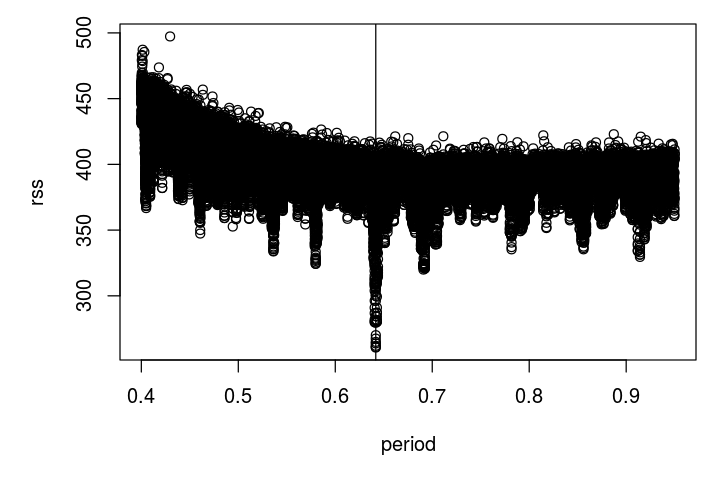

In [18]:
## view rss, still clear min
par(mar=c(5,5,1,1))
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

In [19]:
###### b) use.errors=FALSE, should get poor parameter estimates
rss <- FitTemplate(lc,omegas,tem_sdss,use.errors=FALSE)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss,use.errors=FALSE)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
p_est



mu         ebv         amp       phase 
16.67255250 -0.07362056  2.74861649  0.20413764

[1] 0.743815

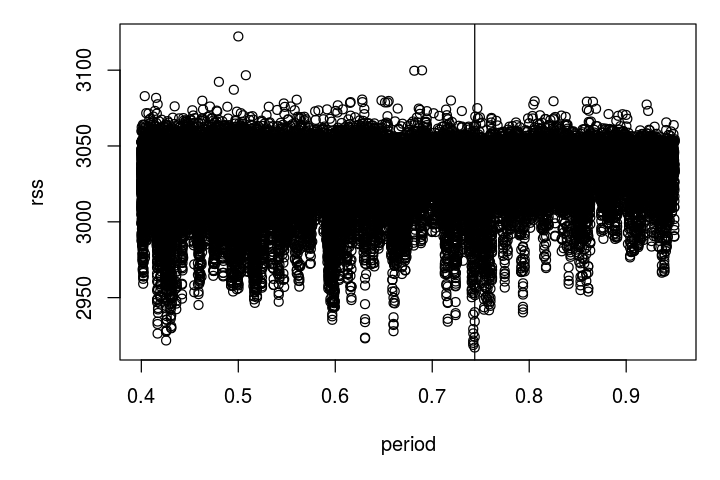

In [20]:
## view rss, very messy
par(mar=c(5,5,1,1))
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

### DEMO 4

Compare templates on a light curve observed by sdss (well sampled) and DES (poorly sampled).

In [22]:
## read in sdss data
fname <- "LC_402316.dat"
lc_sdss <- read.table(fname,stringsAsFactors=FALSE)
names(lc_sdss) <- c("time","band","mag","error")

In [23]:
## fit model
rss_sdss <- FitTemplate(lc_sdss,omegas,tem_sdss)
omega_est_sdss <- omegas[which.min(rss_sdss)]
p_est_sdss <- 1/omega_est_sdss
coeffs_sdss <- ComputeCoeffs(lc_sdss,omega_est_sdss,tem_sdss)
names(coeffs_sdss) <- c("mu","ebv","amp","phase")
coeffs_sdss

mu         ebv         amp       phase 
19.25028294  0.04326845  1.23483084  0.88799892

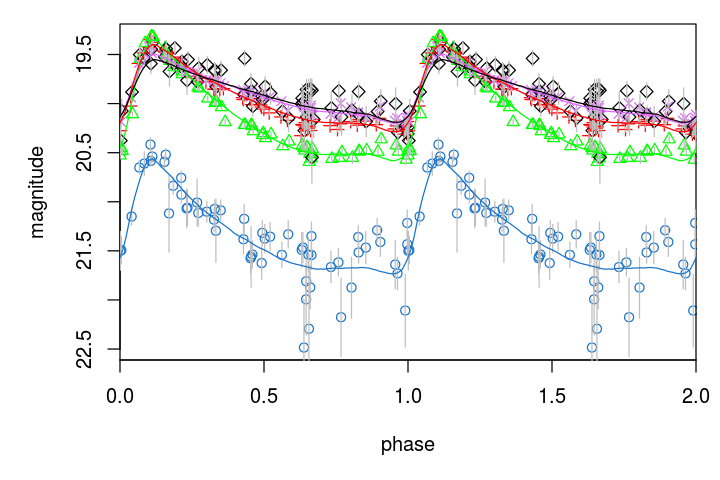

In [24]:
## plot folded light curve with best fit
par(mar=c(5,5,1,1))
plotLC(lc_sdss,p_est_sdss,coeffs_sdss,tem_sdss)

In [25]:
## read in des data for same light curve
fname <- "LC_402316_des.dat"
lc_des <- read.table(fname,header=TRUE,stringsAsFactors=FALSE)
lc_des <- lc_des[,c(1,4,2,3)]
names(lc_des) <- c("time","band","mag","error")

In [27]:
## estimate period with des templates
rss_des <- FitTemplate(lc_des,omegas,tem_des)
omega_est_des <- omegas[which.min(rss_des)]
p_est_des <- 1/omega_est_des
coeffs_des <- ComputeCoeffs(lc_des,omega_est_des,tem_des)
names(coeffs_des) <- c("mu","ebv","amp","phase")

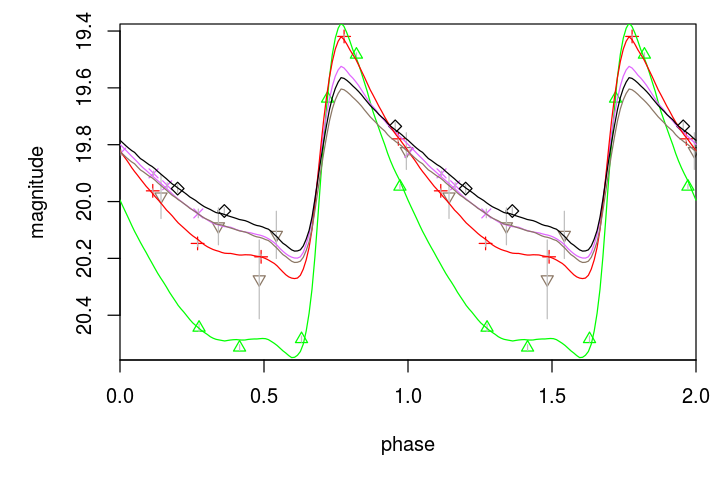

In [28]:
## plot folded light curve with best fit
par(mar=c(5,5,1,1))
plotLC(lc_des,p_est_des,coeffs_des,tem_des)

[1] 0.5430853

[1] 0.5430782

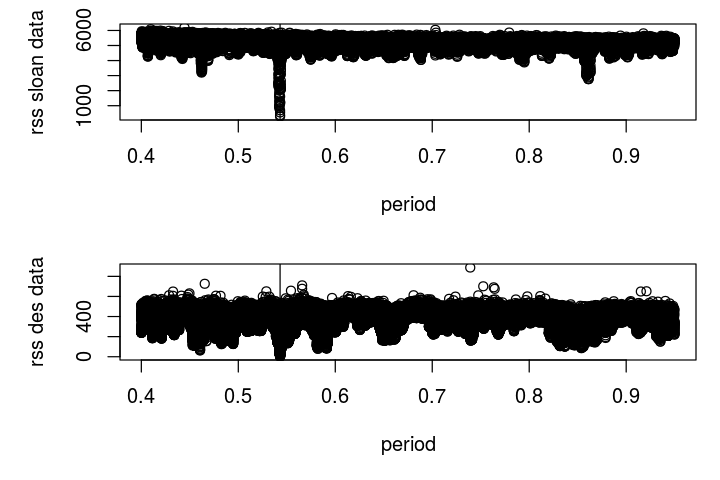

In [29]:
## plot rss functions for sdss and des
## DES minima still clear
par(mfcol=c(2,1),mar=c(5,5,1,1))
plot(1/omegas,rss_sdss,xlab="period",ylab="rss sloan data")
abline(v=p_est_sdss)
plot(1/omegas,rss_des,xlab="period",ylab="rss des data")
abline(v=p_est_des)


p_est_des
p_est_sdss